In [3]:
import os  # helps you to interact with operating system, 
# managing files and directories 
# finding current directories, 
# working with enviornment variables 
import pandas as pd  # for dataframe 
import numpy as np  # handaling arrays
import cv2  # used for image processing and computer vision
# read and write files, Object detections(faces) and more 
import matplotlib.pyplot as plt 
from tqdm import tqdm # shows the level of progress
import random 
import concurrent.futures # for parallel execution of tasks 
import seaborn as sns
import pickle

## Sample Image

(-0.5, 1023.5, 730.5, -0.5)

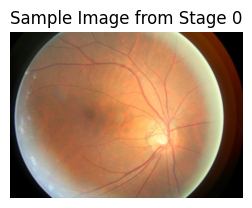

In [4]:
# visualizing an image from a train set 
train_path = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/train"
sample_imgpath = os.path.join(train_path,"0",os.listdir(os.path.join(train_path,"0"))[0])

# read image using OpenCV
img = cv2.imread(sample_imgpath) # cv2 loads image in BGR format only by default 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title("Sample Image from Stage 0")
plt.axis("off")

## Creating Dataset

In [5]:

# root directory where train, test, and val folders are located
root_dir = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2"  # Change this to your actual path

# Function to create a dataframe from a given directory
def create_dataframe(split):
    data = []
    split_path = os.path.join(root_dir, split)  # train, test, or val

    for label in os.listdir(split_path):  # 0, 1, 2, 3, 4
        label_path = os.path.join(split_path, label)
        
        if os.path.isdir(label_path):  # Ensure it's a directory
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append((img_path, int(label)))  # Store path and label as int

    return pd.DataFrame(data, columns=["image_path", "label"])

# Create DataFrames for train, val, and test
train_df = create_dataframe("train")
val_df = create_dataframe("val")
test_df = create_dataframe("test")


print("Shape of train_df",train_df.shape)
print("Shape of train_df",test_df.shape)
print("Shape of train_df",val_df.shape)


Shape of train_df (73995, 2)
Shape of train_df (9261, 2)
Shape of train_df (9245, 2)


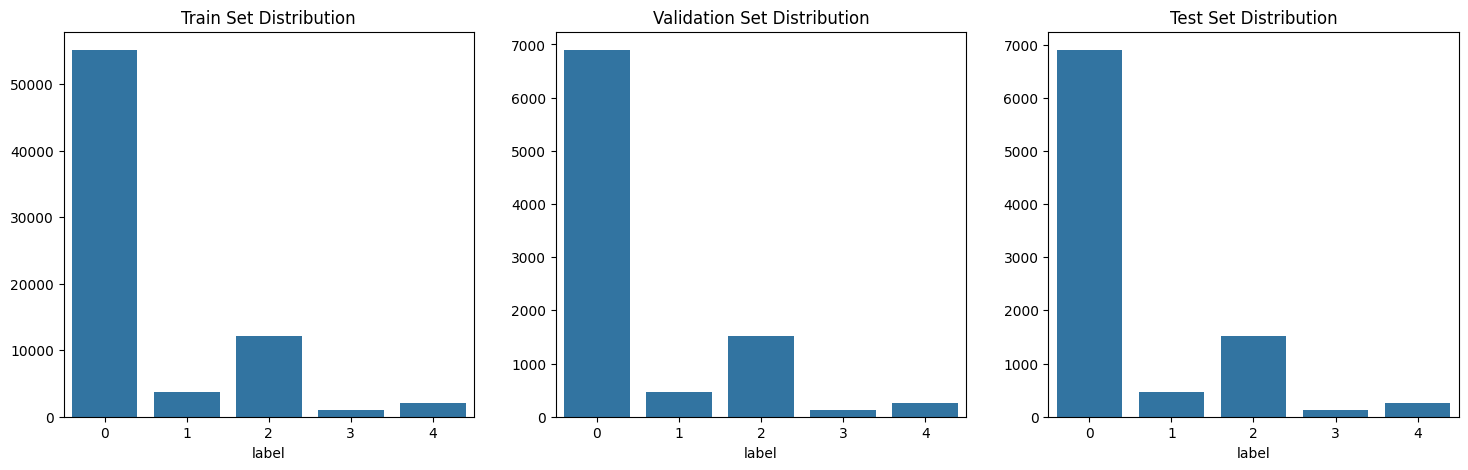

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x=train_df['label'].value_counts().index, y=train_df['label'].value_counts().values, ax=axes[0])
axes[0].set_title("Train Set Distribution")

sns.barplot(x=val_df['label'].value_counts().index, y=val_df['label'].value_counts().values, ax=axes[1])
axes[1].set_title("Validation Set Distribution")

sns.barplot(x=test_df['label'].value_counts().index, y=test_df['label'].value_counts().values, ax=axes[2])
axes[2].set_title("Test Set Distribution")

plt.show()

This shows that our dataset is highly imbalanced. There are more number of images of stage 0 which might build our model biased

In [5]:
train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

## Distribution of Images 

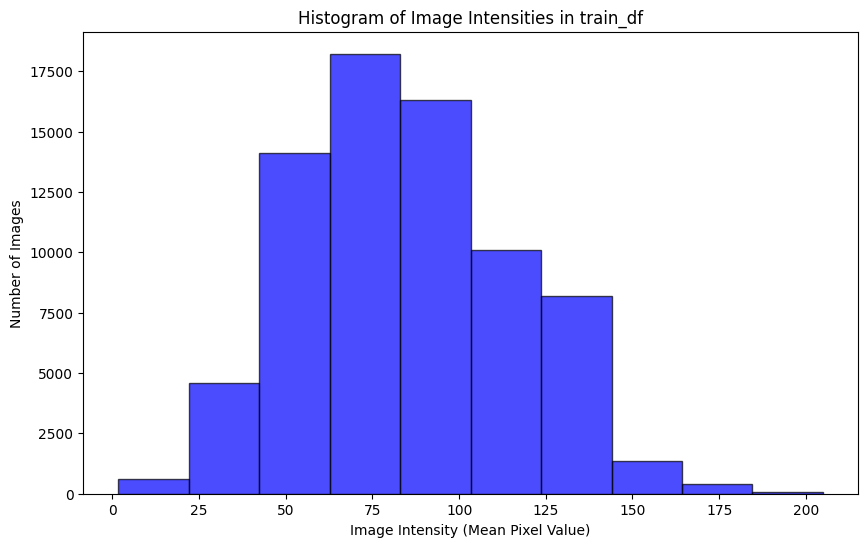

In [6]:
# Function to calculate the average intensity of an image
def calculate_intensity(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    return np.mean(img)  # Calculate mean intensity

# Apply the function to all images in train_df
train_df['intensity'] = train_df['image_path'].apply(calculate_intensity)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(train_df['intensity'], bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Image Intensity (Mean Pixel Value)")
plt.ylabel("Number of Images")
plt.title("Histogram of Image Intensities in train_df")
plt.show()

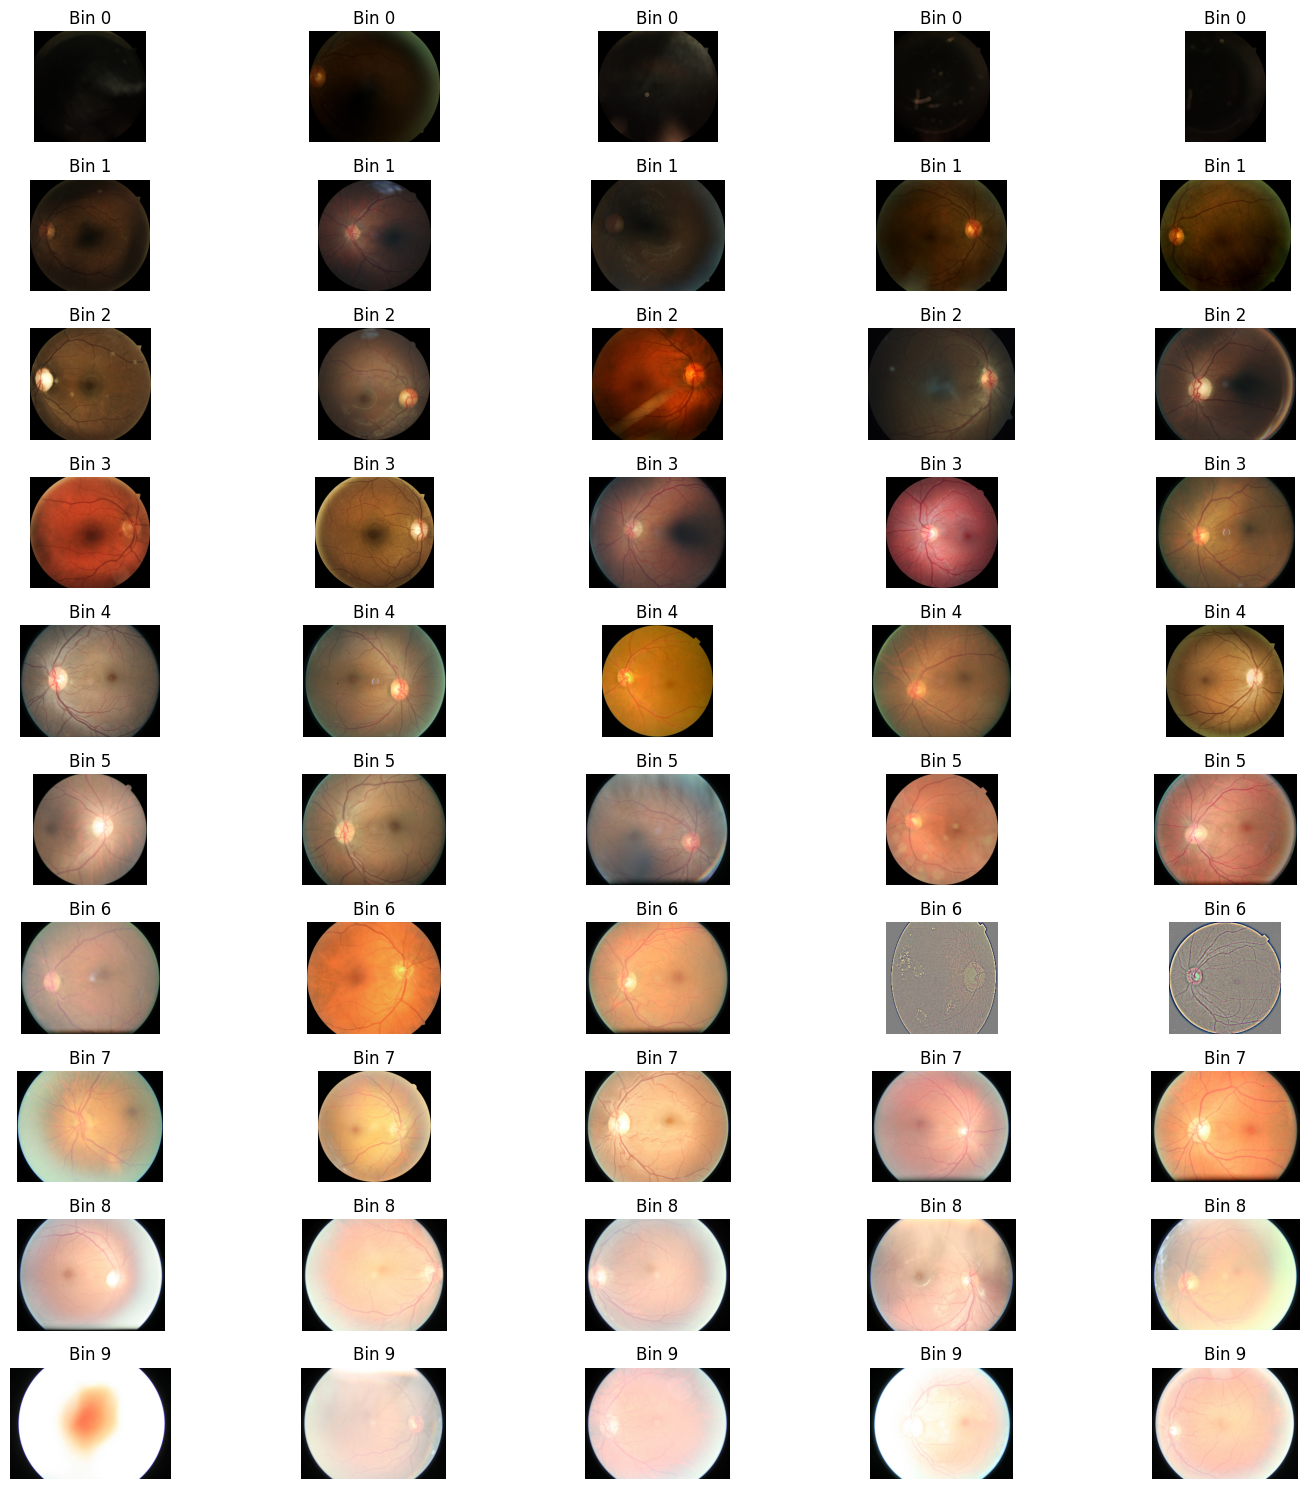

In [7]:
# Define number of bins
num_bins = 10

# Bin images based on intensity
train_df['bin'] = pd.cut(train_df['intensity'], bins=num_bins, labels=False)

# Function to display 5 random images from each bin
def show_images_from_bins(df, num_samples=5):
    unique_bins = df['bin'].unique()
    fig, axes = plt.subplots(len(unique_bins), num_samples, figsize=(15, 15))

    for i, bin_value in enumerate(sorted(unique_bins)):
        bin_images = df[df['bin'] == bin_value].sample(n=min(num_samples, len(df[df['bin'] == bin_value])), random_state=42)

        for j, (_, row) in enumerate(bin_images.iterrows()):
            img = cv2.imread(row['image_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"Bin {bin_value}")

    plt.tight_layout()
    plt.show()

# Show images from each bin
show_images_from_bins(train_df)

## Resizing Images

In [6]:
resized_dir = os.path.join(root_dir, "resized_train")
os.makedirs(resized_dir, exist_ok=True)  

# Function to resize and save images
def resize_image(row, target_size=(456, 456)):  
    img_path = row['image_path']
    img = cv2.imread(img_path)
    
    if img is not None:
        img = cv2.resize(img, target_size)
        new_path = os.path.join(resized_dir, os.path.basename(img_path))
        cv2.imwrite(new_path, img)
        return new_path  # Return new image path
    
    return None  # If image loading fails

# Parallel processing for resizing images
def resize_and_save_images(df, target_size=(456, 456)):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(
            executor.map(lambda row: resize_image(row, target_size), df.to_dict(orient='records')),
            total=len(df),
            desc="Resizing images"
        ))
    
    df['resized_image_path'] = results
    return df

# Resize images and update DataFrame
train_df = resize_and_save_images(train_df)

# Save the updated DataFrame as CSV
train_df.to_csv("resizedtrain.csv", index=False)

Resizing images: 100%|██████████| 73995/73995 [01:41<00:00, 725.93it/s]


In [7]:
train_df.head()

,image_path,label,resized_image_path
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...


1. Since images are of different sizes, resizing ensures they are on the same scale
2. Many pretrained models require a fixed input size

# Function to convert BGR to RGB and store in resized_df

In [10]:
rgb_dir = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/rgb_img"
os.makedirs(rgb_dir, exist_ok=True)

# Function to convert BGR to RGB and save images
def convert_bgr_to_rgb(row):
    img_path = row['resized_image_path']
    img = cv2.imread(img_path)
    
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_path = os.path.join(rgb_dir, os.path.basename(img_path))
        cv2.imwrite(new_path, img_rgb)
        return new_path  # Return new image path
    
    return None  # If image loading fails

# Parallel processing for converting images
def convert_and_save_images(df):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(
            executor.map(convert_bgr_to_rgb, df.to_dict(orient='records')),
            total=len(df),
            desc="Converting BGR to RGB"
        ))
    
    df['rgb_img_path'] = results
    return df

# Convert images and update DataFrame
train_df = convert_and_save_images(train_df)

# Save the updated DataFrame as CSV
train_df.to_csv("rgbtrain.csv", index=False)


Converting BGR to RGB: 100%|██████████| 73995/73995 [00:33<00:00, 2207.96it/s]


In [11]:
train_df.head()

,image_path,label,intensity,bin,resized_image_path,rgb_img_path
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,122.218802,5,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,90.635179,4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,44.902353,2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,45.971277,2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,58.724107,2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...


# Cropping image

In [8]:
cropped_dir = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/cropped_img"
os.makedirs(cropped_dir, exist_ok=True)

# Function to apply circular mask and crop image
def crop_black_parts(row):
    img_path = row['resized_image_path']
    img = cv2.imread(img_path)
    
    if img is not None:
        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        center = (w // 2, h // 2)
        radius = min(center[0], center[1])
        cv2.circle(mask, center, radius, 255, -1)
        
        img_cropped = cv2.bitwise_and(img, img, mask=mask)
        new_path = os.path.join(cropped_dir, os.path.basename(img_path))
        cv2.imwrite(new_path, img_cropped)
        return new_path  # Return new image path
    
    return None  # If image loading fails

# Parallel processing for cropping images
def crop_and_save_images(df):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(
            executor.map(crop_black_parts, df.to_dict(orient='records')),
            total=len(df),
            desc="Cropping images"
        ))
    
    df['cropped_img_path'] = results
    return df

# Apply cropping and update DataFrame
train_df = crop_and_save_images(train_df)

# Save the updated DataFrame as CSV
train_df.to_csv("croppedtrain.csv", index=False)

Cropping images: 100%|██████████| 73995/73995 [00:34<00:00, 2117.16it/s]


In [9]:
train_df.head()

,image_path,label,resized_image_path,cropped_img_path
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...


# CLAHE for underexposed images

In [11]:
# Define CLAHE function
def apply_clahe(img_path, clip_limit=4.0, tile_grid_size=(8, 8)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    if img is None:
        return None, None  # Return None if image not found

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_img = clahe.apply(img)

    # Convert CLAHE grayscale image back to RGB
    clahe_rgb = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)  

    # Compute average intensity from RGB image (not grayscale)
    avg_intensity = np.mean(clahe_rgb)

    return clahe_rgb, avg_intensity

In [12]:
# Directory to save CLAHE-applied images
clahe_dir = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img"
os.makedirs(clahe_dir, exist_ok=True)

# Apply CLAHE to all grayscale images
clahe_paths = []
intensities = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Applying CLAHE"):
    img_path = row["cropped_img_path"]  # Use cropped image path
    clahe_img, intensity = apply_clahe(img_path)

    if clahe_img is not None:
        new_path = os.path.join(clahe_dir, os.path.basename(img_path))
        cv2.imwrite(new_path, clahe_img)  # Save CLAHE-processed image
        clahe_paths.append(new_path)
        intensities.append(intensity)
    else:
        clahe_paths.append(None)
        intensities.append(None)

# Update DataFrame
train_df["clahe_img_path"] = clahe_paths
train_df["image_intensity"] = intensities

# Save updated DataFrame
train_df.to_csv("clahe_train.csv", index=False)


Applying CLAHE: 100%|██████████| 73995/73995 [02:51<00:00, 431.51it/s]


In [13]:
train_df.head()

,image_path,label,resized_image_path,cropped_img_path,clahe_img_path,image_intensity
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,104.243291
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,91.285963
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.510648
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.918932
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,82.604013


In [14]:
train_df.shape

(73995, 6)

In [15]:
# Filter dataframe for images in the specified intensity range
rows_to_delete = train_df[(train_df['image_intensity'] >= 0) & 
                          (train_df['image_intensity'] < 25)]

# Get the file paths
images_to_delete = rows_to_delete['clahe_img_path']

deleted_count = 0  

# Delete each image file
for img_path in images_to_delete:
    if os.path.exists(img_path):  # Check if file exists
        os.remove(img_path)
        deleted_count += 1  # Increment count
        print(f"Deleted: {img_path}")
    else:
        print(f"File not found: {img_path}")

# Remove rows from train_df
train_df = train_df.drop(rows_to_delete.index).reset_index(drop=True)

# Save the updated dataframe to CSV (overwrite original file)
train_df.to_csv("clahe_train.csv", index=False)  

print(f"\nTotal Images Deleted & Rows Dropped: {deleted_count}")


Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/40544_right.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/1557_left.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/20585_right.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/2857_right.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/15078_left.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/20347_right.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/3517_left.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/34689_left.jpg
Deleted: /Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/clahe_img/36852_

In [16]:
train_df.shape

(73957, 6)

In [17]:
train_df.head()

,image_path,label,resized_image_path,cropped_img_path,clahe_img_path,image_intensity
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,104.243291
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,91.285963
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.510648
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.918932
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,82.604013


In [19]:
train_df = pd.read_csv('/Users/meetsudra/Desktop/clahe_train.csv')

In [20]:
train_df

,image_path,label,resized_image_path,cropped_img_path,clahe_img_path,image_intensity
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,104.243291
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,91.285963
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.510648
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.918932
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,82.604013
...,...,...,...,...,...,...
73952,/Users/meetsudra/Downloads/DiabeticRetino/arch...,2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,89.177968
73953,/Users/meetsudra/Downloads/DiabeticRetino/arch...,2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,94.800270
73954,/Users/meetsudra/Downloads/DiabeticRetino/arch...,2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,59.314337
73955,/Users/meetsudra/Downloads/DiabeticRetino/arch...,2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.454553


In [21]:
train_df.shape

(73957, 6)

# Normalizing the Image

In [22]:
# Create a directory to save normalized images
norm_dir = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/norm_img"
os.makedirs(norm_dir, exist_ok=True)

# Function to normalize and save images
def normalize_and_save(img_path, save_dir):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read image
    if img is None:
        return None  # Return None if image is missing
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0,1]
    
    # Convert to uint8 (0-255) and save
    norm_img = (img * 255).astype(np.uint8)
    save_path = os.path.join(save_dir, os.path.basename(img_path))  # Keep same filename
    cv2.imwrite(save_path, cv2.cvtColor(norm_img, cv2.COLOR_RGB2BGR))  # Save as BGR
    
    return save_path  # Return new file path

In [23]:
# Apply normalization in batches
batch_size = 5000
num_batches = len(train_df) // batch_size + 1
normalized_paths = []

print("Normalizing and saving images in batches...")
for i in tqdm(range(num_batches), desc="Processing batches"):
    batch_paths = train_df["clahe_img_path"].iloc[i * batch_size : (i + 1) * batch_size]  # Get batch
    batch_norm_paths = [normalize_and_save(img_path, norm_dir) for img_path in batch_paths]  # Process batch
    normalized_paths.extend(batch_norm_paths)  # Store results

# Store new paths in DataFrame
train_df["norm_img_path"] = normalized_paths

Normalizing and saving images in batches...


Processing batches: 100%|██████████| 15/15 [03:27<00:00, 13.80s/it]


In [24]:
train_df.to_csv("norm_train.csv", index=False)  

In [26]:
train_df = pd.read_csv("/Users/meetsudra/Desktop/norm_train.csv")

In [27]:
train_df.head()

,image_path,label,resized_image_path,cropped_img_path,clahe_img_path,image_intensity,norm_img_path
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,104.243291,/Users/meetsudra/Downloads/DiabeticRetino/arch...
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,91.285963,/Users/meetsudra/Downloads/DiabeticRetino/arch...
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.510648,/Users/meetsudra/Downloads/DiabeticRetino/arch...
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.918932,/Users/meetsudra/Downloads/DiabeticRetino/arch...
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,82.604013,/Users/meetsudra/Downloads/DiabeticRetino/arch...


In [28]:
train_df.shape

(73957, 7)

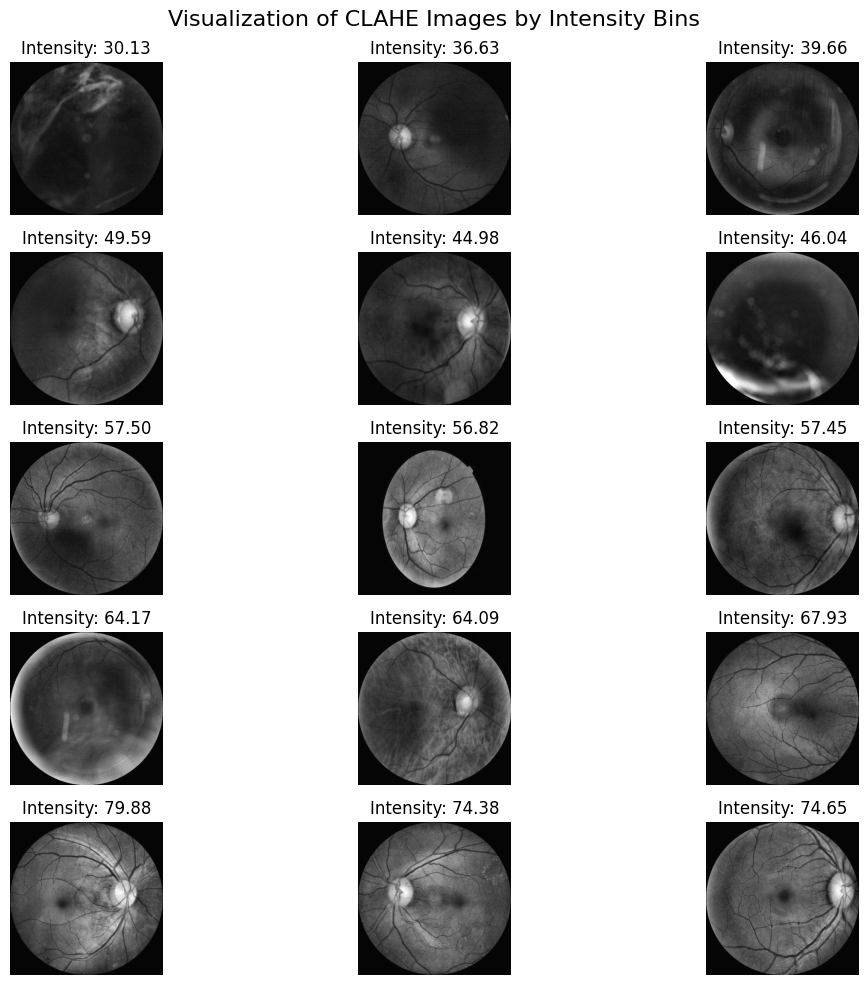

In [29]:
# Define bins
bins = [(30, 40), (40, 50), (50, 60), (60, 70), (70, 80)]
num_images = 3  # Number of images per bin

# Create subplots
fig, axes = plt.subplots(len(bins), num_images, figsize=(12, 10))

for i, (low, high) in enumerate(bins):
    # Filter images for the current bin range
    bin_images = train_df[(train_df['image_intensity'] >= low) & 
                          (train_df['image_intensity'] < high)]
    
    # Select up to `num_images` random images from the bin
    sample_images = bin_images.sample(n=min(num_images, len(bin_images)), random_state=42)
    
    for j, img_path in enumerate(sample_images['clahe_img_path']):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i, j].imshow(img)
        else:
            axes[i, j].text(0.5, 0.5, "Image Not Found", fontsize=12, ha='center', va='center')

        axes[i, j].axis("off")  # Hide axes
        axes[i, j].set_title(f"Intensity: {sample_images.iloc[j]['image_intensity']:.2f}")

# Set row labels for bins
for ax, (low, high) in zip(axes[:, 0], bins):
    ax.set_ylabel(f"{low}-{high}", fontsize=12, rotation=90)

plt.suptitle("Visualization of CLAHE Images by Intensity Bins", fontsize=16)
plt.tight_layout()
plt.show()

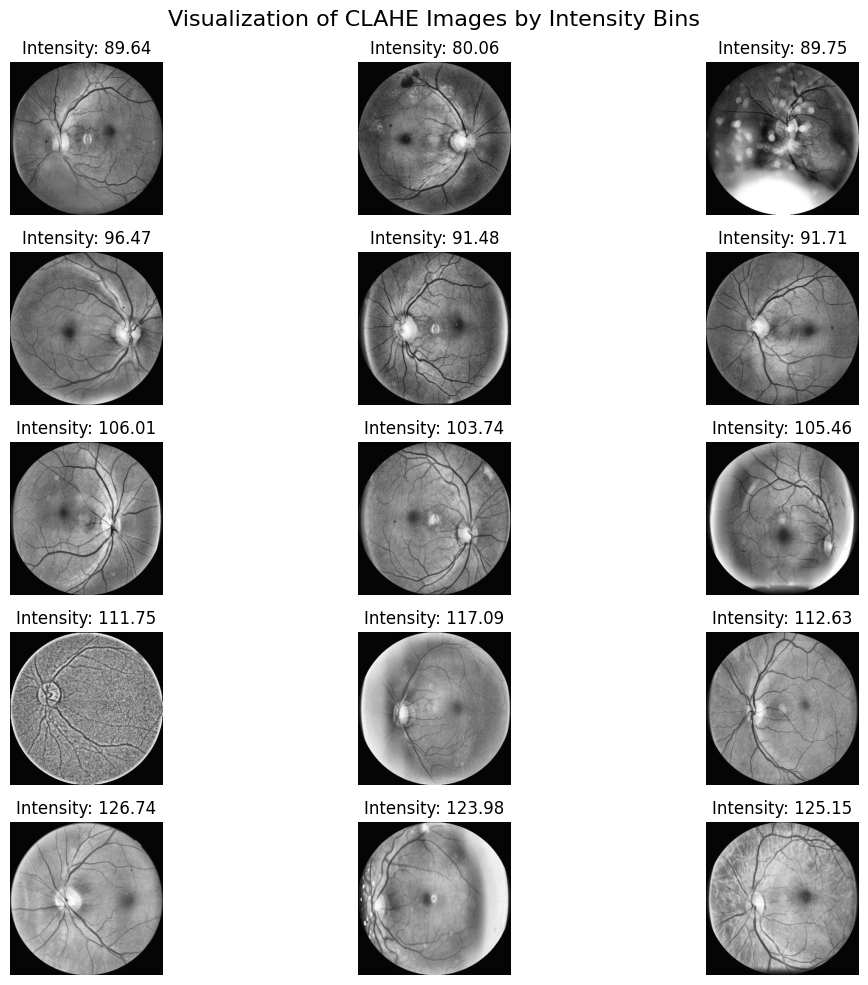

In [17]:
# Define bins
bins = [(80, 90), (90, 100), (100, 110), (110, 120), (120, 130)]
num_images = 3  # Number of images per bin

# Create subplots
fig, axes = plt.subplots(len(bins), num_images, figsize=(12, 10))

for i, (low, high) in enumerate(bins):
    # Filter images for the current bin range
    bin_images = train_df[(train_df['image_intensity'] >= low) & 
                          (train_df['image_intensity'] < high)]
    
    # Select up to `num_images` random images from the bin
    sample_images = bin_images.sample(n=min(num_images, len(bin_images)), random_state=42)
    
    for j, img_path in enumerate(sample_images['clahe_img_path']):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i, j].imshow(img)
        else:
            axes[i, j].text(0.5, 0.5, "Image Not Found", fontsize=12, ha='center', va='center')

        axes[i, j].axis("off")  # Hide axes
        axes[i, j].set_title(f"Intensity: {sample_images.iloc[j]['image_intensity']:.2f}")

# Set row labels for bins
for ax, (low, high) in zip(axes[:, 0], bins):
    ax.set_ylabel(f"{low}-{high}", fontsize=12, rotation=90)

plt.suptitle("Visualization of CLAHE Images by Intensity Bins", fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
# Create directory for gamma-corrected images
gamma_dir = "gamm_corr"
os.makedirs(gamma_dir, exist_ok=True)

def apply_gamma_correction(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Initialize list for new image paths
gamma_corrected_paths = []

In [31]:
# Iterate through the dataset
for idx, row in train_df.iterrows():
    img_path = row["norm_img_path"]
    intensity = row["image_intensity"]
    
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        gamma_corrected_paths.append(None)
        continue
    
    # Apply gamma correction if intensity > 80, else copy as is
    new_img_path = os.path.join(gamma_dir, os.path.basename(img_path))
    if intensity > 80:
        img = apply_gamma_correction(img, gamma=1.2)  # Apply gamma correction
    
    cv2.imwrite(new_img_path, img)  # Save image
    gamma_corrected_paths.append(new_img_path)

# Update dataframe with new paths
train_df["gamm_corr_img_path"] = gamma_corrected_paths

# Save updated dataframe
train_df.to_csv("gamma_corr.csv", index=False)


In [35]:
train_df = pd.read_csv("/Users/meetsudra/Desktop/gamma_corr.csv")

In [36]:
train_df.head()

,image_path,label,resized_image_path,cropped_img_path,clahe_img_path,image_intensity,norm_img_path,gamm_corr_img_path
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,104.243291,/Users/meetsudra/Downloads/DiabeticRetino/arch...,gamm_corr/26576_left.jpg
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,91.285963,/Users/meetsudra/Downloads/DiabeticRetino/arch...,gamm_corr/40024_left.jpg
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.510648,/Users/meetsudra/Downloads/DiabeticRetino/arch...,gamm_corr/18319_right.jpg
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,68.918932,/Users/meetsudra/Downloads/DiabeticRetino/arch...,gamm_corr/11712_right.jpg
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,/Users/meetsudra/Downloads/DiabeticRetino/arch...,82.604013,/Users/meetsudra/Downloads/DiabeticRetino/arch...,gamm_corr/39257_right.jpg


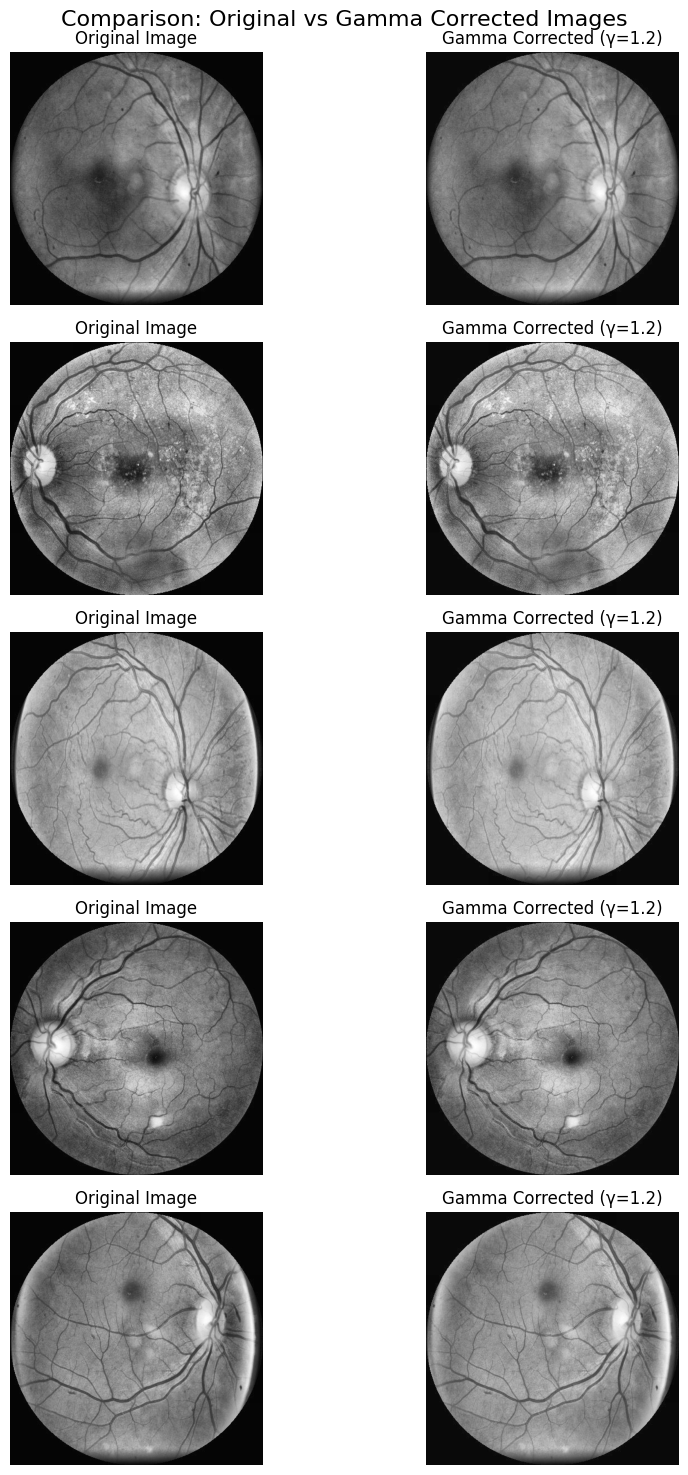

In [37]:
gamma_applied_df = train_df[train_df["image_intensity"] > 80].sample(5, random_state=42)

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, row in enumerate(gamma_applied_df.itertuples()):
    # Load original and gamma-corrected images
    original_img = cv2.imread(row.norm_img_path)
    gamma_corrected_img = cv2.imread(row.gamm_corr_img_path)

    # Convert BGR to RGB for correct color representation
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    gamma_corrected_img = cv2.cvtColor(gamma_corrected_img, cv2.COLOR_BGR2RGB)

    # Plot original image
    axes[i, 0].imshow(original_img)
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Original Image")

    # Plot gamma-corrected image
    axes[i, 1].imshow(gamma_corrected_img)
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Gamma Corrected (γ=1.2)")

# Show the visualization
plt.suptitle("Comparison: Original vs Gamma Corrected Images", fontsize=16)
plt.tight_layout()
plt.show()

# Preprocessing pipeline 

In [ ]:
'''
# Function to perform center crop
# crop_size is a tuple (crop_h, crop_w)

def center_crop(image, crop_size=(400, 400)):
    h, w = image.shape[:2]
    ch, cw = crop_size
    start_y = max((h - ch) // 2, 0)
    start_x = max((w - cw) // 2, 0)
    return image[start_y:start_y+ch, start_x:start_x+cw]

# Function to apply CLAHE
# Here we convert image to LAB color space and apply CLAHE to the L channel

def apply_clahe(image, clipLimit=2.0, tileGridSize=(8,8)):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

# Function to apply gamma correction

def apply_gamma_correction(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(256)]).astype('uint8')
    return cv2.LUT(image, table)

# Preprocessing pipeline that takes an image path, processes the image and returns the preprocessed image

def preprocess_image(img_path, resize_dim=(456,456), crop_size=(400,400), clahe_clip=2.0, gamma=1.2):
    # read image
    image = cv2.imread(img_path)
    if image is None:
        print('Error reading image: ' + img_path)
        return None
    # Step 1: Resize the image
    image = cv2.resize(image, resize_dim)
    
    # Step 2: Center crop the image
    image = center_crop(image, crop_size=crop_size)
    
    # Step 3: Apply CLAHE
    image = apply_clahe(image, clipLimit=clahe_clip)
    
    # Step 4: Apply gamma correction
    image = apply_gamma_correction(image, gamma=gamma)
    
    # Step 5: Normalize image pixels to range [0,1]
    norm_image = image.astype(np.float32) / 255.0
    return norm_image

# Main function: takes a train_df with a column 'img_path', processes images, and outputs a new dataframe
# Also saves the processed images in a new directory

def process_images(train_df, output_dir='preprocessed_images'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output_paths = []
    
    # Iterate over each image path in the dataframe
    for idx, row in train_df.iterrows():
        img_path = row['img_path']
        processed_img = preprocess_image(img_path)
        if processed_img is None:
            output_paths.append(None)  # Or handle error
            continue
        
        # Convert normalized image back to uint8 for saving
        save_img = (processed_img * 255).astype(np.uint8)
        # Create output file name
        base_name = os.path.basename(img_path)
        save_path = os.path.join(output_dir, base_name)
        cv2.imwrite(save_path, save_img)
        output_paths.append(save_path)
        
    # Create a new dataframe based on train_df with a new column for preprocessed image paths
    processed_df = train_df.copy()
    processed_df['preprocessed_img_path'] = output_paths
    return processed_df

# Example usage:
# Assuming train_df is a dataframe with a column 'img_path' containing paths to images
# processed_df = process_images(train_df)
# processed_df.to_csv('processed_images.csv', index=False)
'''